# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.765176,False,-0.233708
1,0.313713,False,-0.472579
2,-1.571352,False,-1.398337
3,1.707349,True,7.620153
4,-1.723321,False,-1.796085
...,...,...,...
995,-0.198451,False,-0.913314
996,0.051515,False,-0.671764
997,-0.361595,False,0.577652
998,-1.176302,True,4.435608


<Axes: xlabel='v0'>

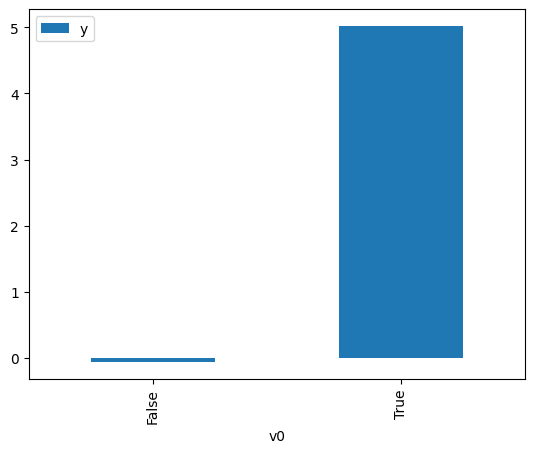

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

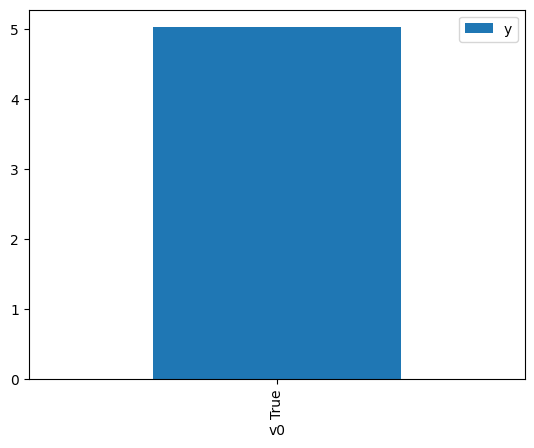

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.539247,False,-0.491868,0.656658,1.522863
1,-1.300574,False,-1.828029,0.827068,1.209091
2,0.473592,False,0.924899,0.361027,2.769874
3,0.473592,False,0.924899,0.361027,2.769874
4,0.517456,False,2.421179,0.348937,2.865847
...,...,...,...,...,...
995,0.251486,False,1.355108,0.424698,2.354616
996,1.106386,False,1.499031,0.208710,4.791344
997,1.126024,False,1.425125,0.204832,4.882049
998,-0.506896,False,0.722044,0.647824,1.543629


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.097471,True,5.969557,0.470886,2.123655
1,0.469866,True,7.574946,0.637937,1.567552
2,1.114532,True,7.722377,0.792905,1.261185
3,1.623682,True,7.960419,0.876044,1.141496
4,0.615164,True,5.784659,0.677290,1.476472
...,...,...,...,...,...
995,0.501882,True,7.575543,0.646792,1.546093
996,-1.121325,True,2.640863,0.206003,4.854305
997,0.181531,True,5.620650,0.554606,1.803081
998,1.239569,True,6.712863,0.816537,1.224685


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8687.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:28:25   Log-Likelihood:                         -1416.7
No. Observations:                1000   AIC:                                      2837.
Df Residuals:                     998   BIC:                                      2847.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5373      0.032     47.707      0.000       1.474       1.601
x2             5.0501      0.048    106.149      0.000       4.957       5.143
==============================================================================
Omnibus:                        1.465   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.540
Skew:                          -0.085   Prob(JB):                        0.463
Kurtosis:                       2.909   Cond. No.                         1.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""